In [1]:
import preprocess
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn import metrics

In [2]:
# %matplotlib osx

# Data Loading

In [3]:
%%time
# load input files
rootdir = '../../data.nosync/'
interictal_count = preprocess.count_interictal_files(rootdir)
interictal_files = preprocess.get_interictal_files(rootdir, interictal_count)
preictal_files = preprocess.get_preictal_files(rootdir)
print('Interictal file count:', len(interictal_files))
print('Preictal file count:', len(preictal_files))

Interictal file count: 480
Preictal file count: 24
CPU times: user 1.85 ms, sys: 5.39 ms, total: 7.24 ms
Wall time: 7.45 ms


In [4]:
# target vector
interictal_y = np.zeros(len(interictal_files))
preictal_y = np.ones(len(preictal_files))
y = np.concatenate((interictal_y, preictal_y), axis=0)
y.shape

(504,)

In [5]:
%%time
# input vector
X_list = []
X_list.extend(interictal_files)
X_list.extend(preictal_files)
X = np.array(X_list)
print(type(X))
X.shape

<class 'numpy.ndarray'>
CPU times: user 407 µs, sys: 163 µs, total: 570 µs
Wall time: 522 µs


(504,)

In [6]:
# summarize class distribution (0=interictal, 1=pre-ictal)
print(Counter(y))

Counter({0.0: 480, 1.0: 24})


In [7]:
# define oversampling strategy due to class imbalance
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X.reshape(-1,1), y)
print(Counter(y_over))

Counter({0.0: 480, 1.0: 480})


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

(643, 1)
(317, 1)


# Data Visualisation

In [21]:
# load sample interictal file
x_interictal = X_train[0]
print('Label:', y_train[0])
filepath = rootdir + x_interictal.item()
print('Load file:', filepath)
mat = sio.loadmat(filepath)
sigbuf = preprocess.get_sig(mat)
sigbuf = sigbuf.astype('float32')
fs = np.rint(preprocess.get_fs(mat))
print('Sampling rate (Hz):', fs)
print(sigbuf.shape)

Label: 0.0
Load file: ../../data.nosync/Dog_1_interictal_segment_0146.mat
Sampling rate (Hz): 400.0
(16, 239766)


In [50]:
EEG = sigbuf.T
print(EEG.shape)
print(EEG[:,0].shape)
print(EEG[:,0])
mean, std = EEG.mean(), EEG.std()
print('mean:', mean)
print('std dev:', std)
EEG = (EEG - mean) / std # normalise
print(EEG[:,0])

(239766, 16)
(239766,)
[ -8.  -9. -13. ...  -2.   9.  17.]
mean: 0.0542237
std dev: 16.843954
[-0.47816706 -0.53753555 -0.77500945 ... -0.12195615  0.5310972
  1.006045  ]


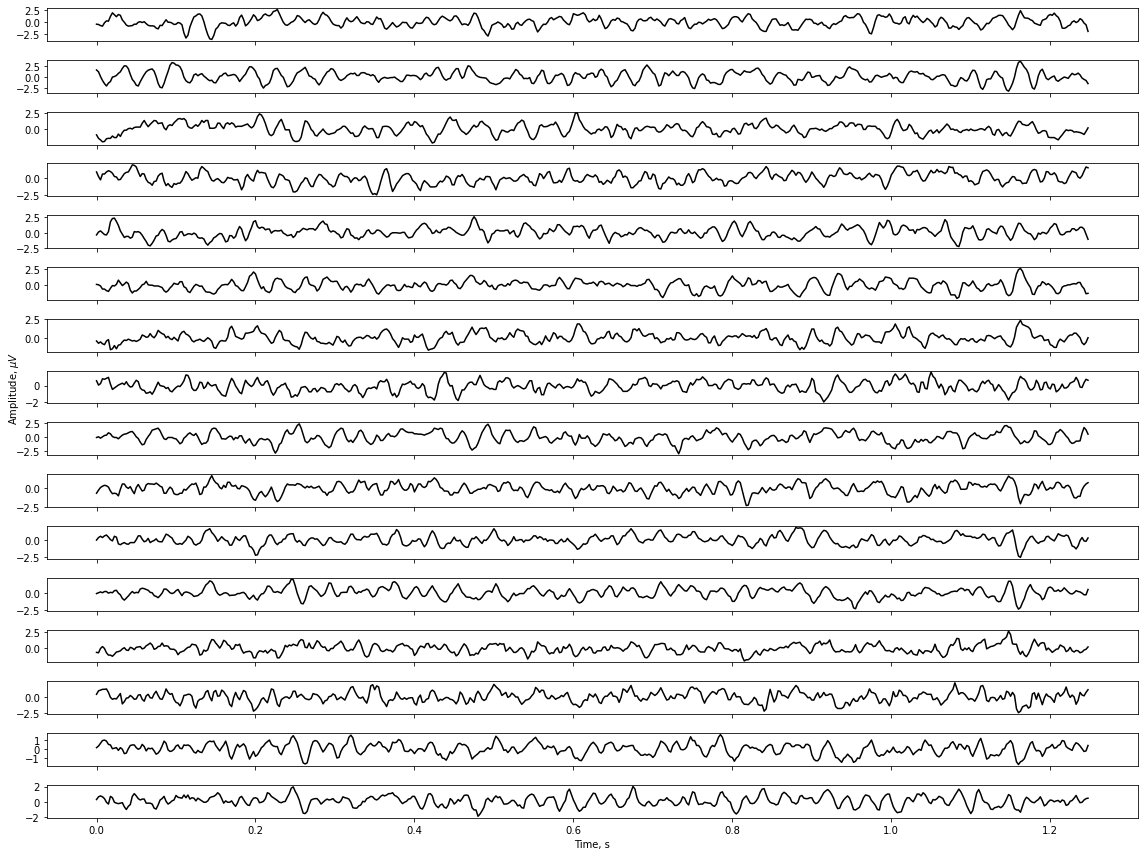

In [58]:
# visualise raw signal
# EEG = sigbuf.T
# N = len(EEG)
N = 500
t = np.arange(0,N)/fs
fig, axes = plt.subplots(figsize=(16,12), nrows=16, ncols=1, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t, EEG[:N,i], color='k')
plt.xlabel('Time, s')
axes[7].set_ylabel('Amplitude, $\mu V$')
fig.tight_layout()

In [61]:
EEG_flat = EEG.flatten()
EEG_flat.shape

(3836256,)

The lines appear 'dense', will rescaling the data help?

In [ ]:
def rescale_ch(signal, smin, smax):
    signal = signal.reshape((len(signal), 1))
    scaler = MinMaxScaler(feature_range=(smin,smax))
    scaler = scaler.fit(signal)
    rescaled = scaler.transform(signal)
    rescaled = rescaled.reshape((-1,))
    return rescaled

In [ ]:
# rescale data to range [0,1]
rescaled_EEG = np.empty_like(EEG)
for i in range(EEG.shape[1]):
    rescaled_EEG[:,i] = rescale_ch(EEG[:,i], smin=0, smax=1)

In [ ]:
# rescale data to range [-1,1]
rescaled_EEG = np.empty_like(EEG)
for i in range(EEG.shape[1]):
    rescaled_EEG[:,i] = rescale_ch(EEG[:,i], smin=-1, smax=1)

Rescaling between [0,1] makes the signal appear flat with pulses. The same is true for range [-1,1] but this time the pulses appear in the negative axis too.

In [ ]:
# rescale data to range [-10,10]
rescaled_EEG = np.empty_like(EEG)
for i in range(EEG.shape[1]):
    rescaled_EEG[:,i] = rescale_ch(EEG[:,i], smin=-10, smax=10)

Between [-10,10] the signal is less flat but it still looks abnormal compared to raw eeg as there are periods of flatness between oscillations.

In [ ]:
# rescale data to range [-100,100]
rescaled_EEG = np.empty_like(EEG)
for i in range(EEG.shape[1]):
    rescaled_EEG[:,i] = rescale_ch(EEG[:,i], smin=-100, smax=100)

Rescaling is clearly impacting the signal oscillations. We shall perform experiments to determine the optimal scale when assessing knn performance.

In [ ]:
# visualise rescaled signal
N = len(rescaled_EEG)
t = np.arange(0,N)/fs
fig, axes = plt.subplots(figsize=(20,12), nrows=16, ncols=1, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t, rescaled_EEG[:,i], color='k')
plt.xlabel('Time, s')
axes[7].set_ylabel('Amplitude, $\mu V$')
fig.tight_layout()

# Data Preprocessing

In [68]:
# convert to z-score and flatten training set
X_train_EEG = np.zeros((643, 3836256))
for i in tqdm(range(len(X_train))):
    filepath = rootdir + X_train[i].item()
    mat = sio.loadmat(filepath)
    sigbuf = preprocess.get_sig(mat).astype('float32')
    mean, std = sigbuf.mean(), sigbuf.std()
    sigbuf = (sigbuf - mean) / std # normalise
    X_train_EEG[i,:] = sigbuf.flatten()

100%|██████████| 643/643 [02:01<00:00,  5.30it/s]


In [70]:
# convert to z-score and flatten test set
X_test_EEG = np.zeros((317, 3836256))
for i in tqdm(range(len(X_test))):
    filepath = rootdir + X_test[i].item()
    mat = sio.loadmat(filepath)
    sigbuf = preprocess.get_sig(mat).astype('float32')
    mean, std = sigbuf.mean(), sigbuf.std()
    sigbuf = (sigbuf - mean) / std # normalise
    X_test_EEG[i,:] = sigbuf.flatten()

100%|██████████| 317/317 [01:03<00:00,  4.97it/s]


In [ ]:
# rescale signal in range [-100,100]
# X_train_EEG = np.zeros((643, 16, 239766))

# for i in tqdm(range(len(X_train))):
#     filepath = rootdir + X_train[i].item()
#     mat = sio.loadmat(filepath)
#     sigbuf = preprocess.get_sig(mat)
#     rescaled_sigbuf = np.empty_like(sigbuf)
#     for j in range(sigbuf.shape[0]):
#         rescaled_sigbuf[j,:] = rescale_ch(sigbuf[j,:], smin=-100, smax=100)
#     X_train_EEG[i] = rescaled_sigbuf

In [ ]:
# rescale signal in range [-100,100]
# X_test_EEG = np.zeros((317, 16, 239766))

# for i in tqdm(range(len(X_test))):
#     filepath = rootdir + X_test[i].item()
#     mat = sio.loadmat(filepath)
#     sigbuf = preprocess.get_sig(mat)
#     rescaled_sigbuf = np.empty_like(sigbuf)
#     for j in range(sigbuf.shape[0]):
#         rescaled_sigbuf[j,:] = rescale_ch(sigbuf[j,:], smin=-100, smax=100)
#     X_test_EEG[i] = rescaled_sigbuf

# Model Building

## k-Nearest Neighbour

In [84]:
%%time
k = 5
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train_EEG, y_train)

CPU times: user 5.55 s, sys: 54.5 s, total: 1min
Wall time: 2min 32s


KNeighborsClassifier()

In [ ]:
%%time
# Predict the response for test dataset
y_pred = model.predict(X_test_EEG)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [83]:
X_train_EEG.shape

(643, 3836256)

3-dimensional input is incompatible with kNN classifier. One strategy is to reshape the input to `(643, 16*239766)` which will result in a new 2-dimensional array which preserves all the information in 3D array but results in the kNN not being able to take advantage of the implicit structure of temporal data.

In [ ]:
X_train_EEG_2d = X_train_EEG.reshape(-1, 16*239766)
X_train_EEG_2d.shape

In [ ]:
%%time
k = 5
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train_EEG_2d, y_train)

Before evaluating the test set, we need to perform the same kind of dimensionality reduction.

In [ ]:
X_test_EEG_2d = X_test_EEG.reshape(-1, 16*239766)
X_test_EEG_2d.shape

In [ ]:
%%time
# Predict the response for test dataset
y_pred = model.predict(X_test_EEG_2d)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))